In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [2]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
import pandas as pd

# Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [3]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [4]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1, opt_gamma_search=False, expl_formula_opt=False):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self._n_estimators = n_estimators
        self._max_depth = max_depth
        self._learning_rate = learning_rate
        self._estimators = []
        self._opt_gamma_search = opt_gamma_search
        self._expl_formula_opt = expl_formula_opt
        if self._opt_gamma_search:
            self._gammas = []
        else:
            self._gamma = 1
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        self._main_y = y.copy()
        y_new = y.copy()
        for estimator_num in range(self._n_estimators):
            
            y_hat = self._fit_predict_tree(x, y_new)
            y_new -= y_hat

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self._max_depth, random_state=19052019)
        tree.fit(x, y)
        self._estimators.append(tree)
        
        # Найдем опт гамму, если требуется
        if self._opt_gamma_search:
            
            prev_yhat = np.zeros(len(y))
            for estimator, gamma in zip(self._estimators[:-1], self._gammas):
                prev_yhat += estimator.predict(x) * self._learning_rate * gamma  # Собираем a(N-1)
            
            new_yhat = self._estimators[-1].predict(x)  # b(N)
            
            if not self._expl_formula_opt:
                
                f = lambda gamma: ((self._main_y - (prev_yhat + gamma * new_yhat)) ** 2).mean()  # Присваивать переменным лямбды не оч круто, но все же
                opt_gamma = minimize(f, 1).x[0]
            
            # Оптимизация через нахождение явной формулы для гаммы (МСЕ - сумма положит парабол => сущ-ет единственный экстремум, который
            # является минимумом). Найти можно из dL / d_gamma = 0.
            else:
                opt_gamma = (-1 * new_yhat * prev_yhat + self._main_y * new_yhat).sum() / (new_yhat * new_yhat).sum()
            self._gammas.append(opt_gamma)
            return opt_gamma * self._learning_rate * tree.predict(x) 
            
        else:
            return self._gamma * self._learning_rate * tree.predict(x) 
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(shape=x.shape[0])
        if self._opt_gamma_search:
            for estimator, gamma in zip(self._estimators, self._gammas):
                y_pred += gamma * self._learning_rate * estimator.predict(x)
        else:
            for estimator in self._estimators:
                y_pred += self._gamma * self._learning_rate * estimator.predict(x)
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [5]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [7]:
# Гиперпараметры я нашел через простой перебор.
my_GB = GradientBoosting(n_estimators=420, max_depth=6, learning_rate=0.095, opt_gamma_search=False)
my_GB.fit(X_train, y_train)
y_pred = my_GB.predict(X_test)
print(f'{mean_squared_error(y_test, y_pred)} <- MSE при обычной реализации без подбора оптимальной гамма')

9.316476741352272 <- MSE при обычной реализации без подбора оптимальной гамма


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

# *ДА*

**К тому же я попробовал два метода оптимизации:**
- Просто выразить оптимальную гамму в явном виде
- Использовать встроенную в сай-пай функцию минимизации (хз, какой конкретно алгоритм она внутри использует, не обращал внимания) 

**Поиск опт. гаммы в явном виде:**

In [8]:
my_GB = GradientBoosting(n_estimators=420, max_depth=6, learning_rate=0.095, opt_gamma_search=True, expl_formula_opt=True)
my_GB.fit(X_train, y_train)
y_pred = my_GB.predict(X_test)
print(f'{mean_squared_error(y_test, y_pred)} <- MSE при подборе оптимальной гамма в явном виде')

9.531546469584958 <- MSE при подборе оптимальной гамма в явном виде


**Поиск опт. гаммы с помощью сай-пай:**

In [9]:
my_GB = GradientBoosting(n_estimators=420, max_depth=6, learning_rate=0.095, opt_gamma_search=True)
my_GB.fit(X_train, y_train)
y_pred = my_GB.predict(X_test)
print(f'{mean_squared_error(y_test, y_pred)} <- MSE при подборе оптимальной гамма с помощью сай-пая')

9.316476741352272 <- MSE при подборе оптимальной гамма с помощью сай-пая


**Гиперпараметры, используемые тут, могут быть не самыми оптимальными, но они бьют пороговый МСЕ, так что использую их.**

***Интересный* момент!**
<br>В моем случае все оптимальные гаммы равны 1. Выглядит слегка подозрительно, но косяка в коде не вижу, так что вот.

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [10]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [11]:
# Референс

from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import OneHotEncoder as OHE

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_default = XGBClassifier()
xgb_default.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_default.predict_proba(X_valid)[:, 1])

C:\Users\ikhrenkov\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6990943345780409

**Проведем небольшое исследование данных, чтобы использовать не только признаки Dist и DepTime**

In [12]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


Мне кажется, задержки зависят от перевозчика

In [13]:
train['UniqueCarrier'].value_counts()

WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: UniqueCarrier, dtype: int64

И от аэропорта вылета тоже почти наверняка есть зависимость

In [14]:
train['Origin'].value_counts()

ATL    5834
ORD    4870
DFW    4270
LAX    3259
IAH    3048
       ... 
ADK       1
ILG       1
VCT       1
WYS       1
VIS       1
Name: Origin, Length: 289, dtype: int64

И, возможно, от дня недели. Например, есть более загруженные дни, в которые вероятность ошибок и => задержек выше

In [15]:
train['DayOfWeek'].value_counts()

c-4    14736
c-5    14657
c-2    14604
c-1    14569
c-3    14508
c-7    14097
c-6    12829
Name: DayOfWeek, dtype: int64

**Попробуем превратить данные переменные в даммисы и построить град. буст. классификатор**

In [16]:
dummies = pd.get_dummies(train[['DayOfWeek', 'Origin', 'UniqueCarrier', 'DayofMonth', 'Month']])
train_with_dummies = train.drop(columns=['DayOfWeek', 'Origin', 'UniqueCarrier', 'Month', 'DayofMonth', 'Dest', 'dep_delayed_15min'])
train_with_dummies = pd.concat([train_with_dummies, dummies], axis=1)

In [17]:
train_with_dummies

,DepTime,Distance,DayOfWeek_c-1,DayOfWeek_c-2,DayOfWeek_c-3,DayOfWeek_c-4,DayOfWeek_c-5,DayOfWeek_c-6,DayOfWeek_c-7,Origin_ABE,...,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,Month_c-5,Month_c-6,Month_c-7,Month_c-8,Month_c-9
0,1934,732,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1548,834,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1422,416,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1015,872,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1828,423,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1618,199,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
99996,804,884,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,1901,1076,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,1515,140,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [18]:
X_train = train_with_dummies.values

In [19]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_default = XGBClassifier(n_estimators=150)
xgb_default.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_default.predict_proba(X_valid)[:, 1])

C:\Users\ikhrenkov\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7439409030610629

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [20]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [262]:
def check_for_presence_in_clustered(point, clustered_ones):
    """
    Функция которая поможет для точки определить, кластеризована ли она или нет
    """
    return not tuple(point) in clustered_ones

presence_check_vectorized = np.vectorize(check_for_presence_in_clustered, signature='(n),()->()', excluded=['point'])

def dist(a, b):
    """Метрика расстояния"""
    # Попробуйте что-нибудь из scipy.spatial.distance
    # Базовый вариант -- Евклидова метрика
    return distance.pdist([a, b], 'minkowski', p=2)

dist_vectorized = np.vectorize(dist, excluded=['a'], signature='(n),(n)->()')

In [263]:
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self._eps = eps
        self._min_samples = min_samples
        
    def fit_predict(self, X):
        self._X = X  # Множество всех точек идущих на вход
        self._clustered = dict()  # Ключ - точка (кортеж как тип данных)
        
        self._clusters = np.empty(shape=0)
        for point in X:
            if tuple(point) not in self._clustered:
                neighbors = self.range_query(point)  # Если она не кластеризованная - вернем соседей
                if neighbors.shape[0] >= self._min_samples:  # Данная точка является основной. Вокруг нее можно строить кластер
                    self.grow_cluster(point, neighbors)
            
            if tuple(point) in self._clustered:
                self._clusters = np.append(self._clusters, self._clustered[tuple(point)])
            else:
                self._clusters = np.append(self._clusters, 0)
                
        return self._clusters
        
    def grow_cluster(self, root, neighbours):
        
        if len(self._clustered.keys()) == 0:  # Самый первый кластер в пространстве помечаем как 0
            current_cluster = 1
        else:
            current_cluster = np.array(list(self._clustered.values())).max() + 1
            
        self._clustered[tuple(root)] = current_cluster
        
        while neighbours.shape[0] > 0:
            
            new_neighbors = np.empty(shape=(0, self._X.shape[1]))
            
            for neighbor in neighbours:
                
                self._clustered[tuple(neighbor)] = current_cluster  # Присвоили точке определенный кластер
                second_order_neighbors = self.range_query(neighbor)
                
                if second_order_neighbors.shape[0] >= self._min_samples:  # Данная точка точно основная => продолжаем растить кластер. Еcли критерий не проходит, то это уже граничная точка => по ней кластер не растим

                    not_clustered_yet = second_order_neighbors[presence_check_vectorized(second_order_neighbors, self._clustered)]
                    new_neighbors = np.vstack([new_neighbors, not_clustered_yet])
                    
            neighbours = np.unique(new_neighbors, axis=0)
        
    
    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        return self._X[dist_vectorized(x, self._X) <= self._eps]

Проверим себя на простом примере:

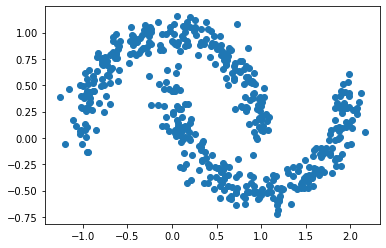

In [264]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

In [265]:
my_dbscan = dbscan(0.2, min_samples=10)
my_clusters = my_dbscan.fit_predict(X)

Референс:

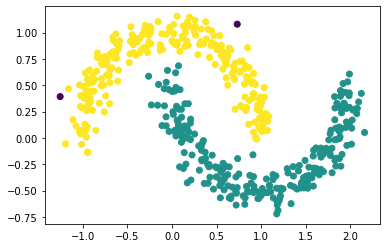

In [266]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

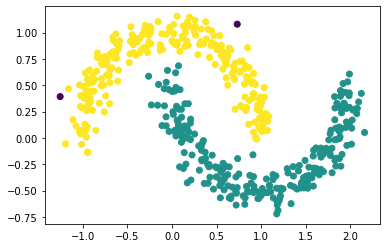

In [267]:
plt.scatter(X[:,0], X[:,1], c=my_clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

Или хотя бы что-нибудь такое: 

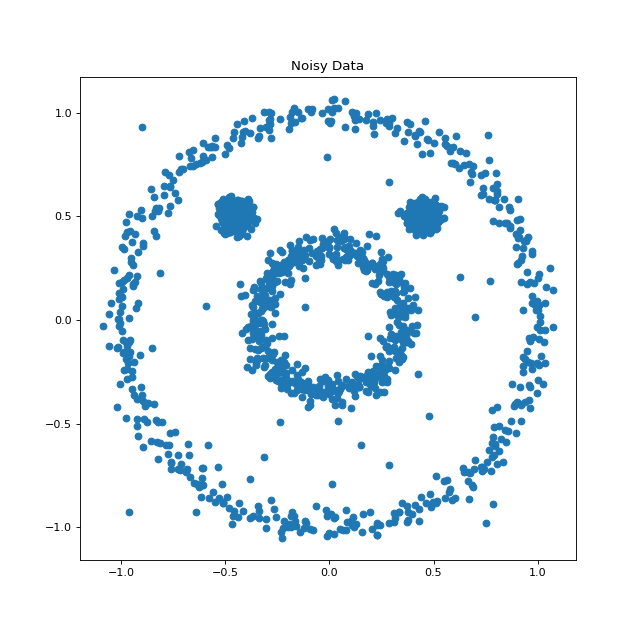

In [206]:
x_axis_big = np.linspace(-1, 1, num=50)
y_axis_big_upper = np.sqrt(1 - x_axis_big ** 2) + np.random.normal(size=x_axis_big.shape[0], scale=.1 / 2)
y_axis_big_lower = - np.sqrt(1 - x_axis_big ** 2) + np.random.normal(size=x_axis_big.shape[0], scale=.1 / 2)
x_axis_small = np.linspace(-1 / 2, 1 / 2, num=50)
y_axis_small_upper = np.sqrt(1 / 2 - (x_axis_small) ** 2) + np.random.normal(size=x_axis_small.shape[0], scale=0.1 / 2)
y_axis_small_lower = - np.sqrt(1 / 2 - (x_axis_small) ** 2) + np.random.normal() + np.random.normal(size=x_axis_small.shape[0], scale=.1 / 2)


small_cirle = np.vstack([np.column_stack((x_axis_small, y_axis_small_lower)), np.column_stack((x_axis_small, y_axis_small_upper))])
bigger_circle = np.vstack([np.column_stack((x_axis_big, y_axis_big_lower)), np.column_stack((x_axis_big, y_axis_big_upper))])

some_more_crazy_x_axis_dots = np.linspace(-.1, .1, num=20)
some_more_crazy_y_axis_dots = some_more_crazy_x_axis_dots + np.random.normal(size=some_more_crazy_x_axis_dots.shape[0], scale=.1)
more_random_points =np.column_stack((some_more_crazy_x_axis_dots, some_more_crazy_y_axis_dots))

some_more_crazy_x_axis_dots2 = np.linspace(.3, .35, num=10)
some_more_crazy_y_axis_dots2 = some_more_crazy_x_axis_dots2 + np.random.normal(size=some_more_crazy_x_axis_dots2.shape[0], scale=.1 / 4)
more_random_points2 =np.column_stack((some_more_crazy_x_axis_dots2, some_more_crazy_y_axis_dots2))



picture = np.vstack([small_cirle, bigger_circle])
picture = np.vstack([picture, more_random_points])
picture = np.vstack([picture, more_random_points2])

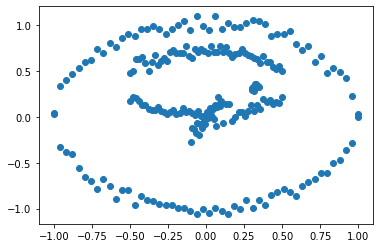

In [207]:
plt.scatter(picture[:, 0], picture[:, 1])
plt.show();

In [250]:
my_dbscan2 = dbscan(0.1, min_samples=7)
my_clusters2 = my_dbscan2.fit_predict(picture)

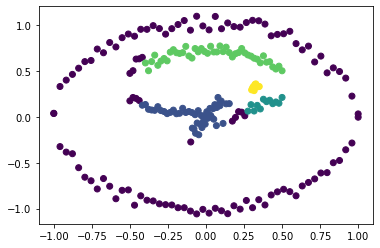

In [251]:
plt.scatter(picture[:,0], picture[:,1], c=my_clusters2)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [248]:
%%time
%%capture
clusters = DBSCAN(eps=0.1, min_samples=7).fit_predict(picture)

Wall time: 0 ns


Ниже пикча работы склёрновского алгоритма

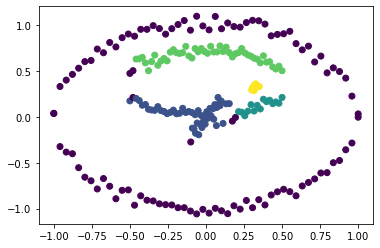

In [249]:
plt.scatter(picture[:,0], picture[:,1], c=clusters)
plt.show()

In [242]:
%%time
%%capture
my_clusters = dbscan(eps=0.2, min_samples=10).fit_predict(picture)

Wall time: 1.08 s


В моем алгоритме много приведений типов (не успел сделать норм) + сплошной цикл + неэффективный менеджмент уже обработанных точек, так немудрено, что он намного медленнее встроенного.